# House Prices: EDA and Machine Learning  

This notebook explores the Kaggle House Prices dataset.  
It covers data exploration, handling missing values, feature engineering, and training different machine learning models.  

Models compared include Linear Regression, Ridge, Lasso, RandomForest, and XGBoost.  
The final predictions are generated using XGBoost and submitted to the competition.  


## 📂 Checking Available Files  
Kaggle datasets are stored under the `/kaggle/input/` directory. The command below lists the files available in this competition.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# 🏡 House Prices Prediction with Machine Learning  

The housing market has always fascinated economists, analysts and homeowners. Being able to predict the sale price of a house based on its features is not just a fun machine learning exercise but also a problem with real-world impact.  

In this notebook I will explore the famous Kaggle competition House Prices: Advanced Regression Techniques. Together we will dive into the data, handle missing values, engineer useful features, train multiple models and finally generate predictions for submission. The goal is not just to chase accuracy but to learn how data science techniques come together to solve a regression problem.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")


## 📂 Loading the Dataset  

The competition provides three files. The training data contains house features along with the target column SalePrice. The test data contains house features without the target column. The sample submission file shows the format in which Kaggle expects the predictions.  


In [3]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

print("Training data shape:", train.shape)
print("Test data shape:", test.shape)
train.head()


Training data shape: (1460, 81)
Test data shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 🔍 Exploratory Data Analysis  

The dataset contains information about 1460 houses with 81 features. Some are numerical such as LotArea or OverallQual while others are categorical such as Neighborhood or Exterior. The target variable SalePrice is right skewed which means applying a logarithmic transformation will make it easier for models to learn patterns. Let us begin by checking missing values and then take a closer look at the target distribution.


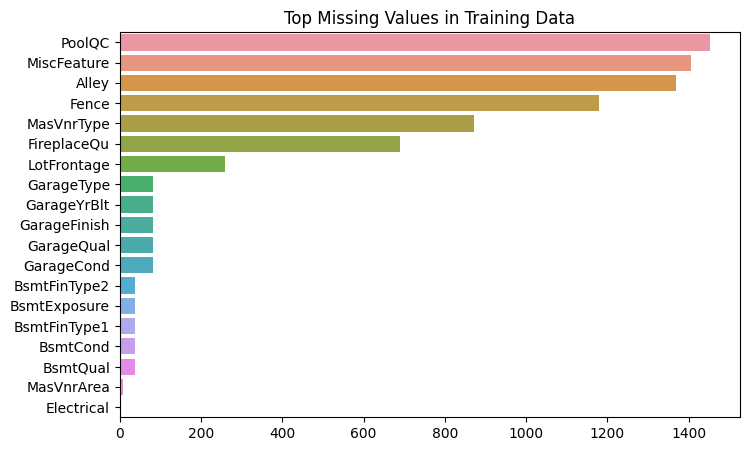

In [4]:
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=missing.values, y=missing.index)
plt.title("Top Missing Values in Training Data")
plt.show()


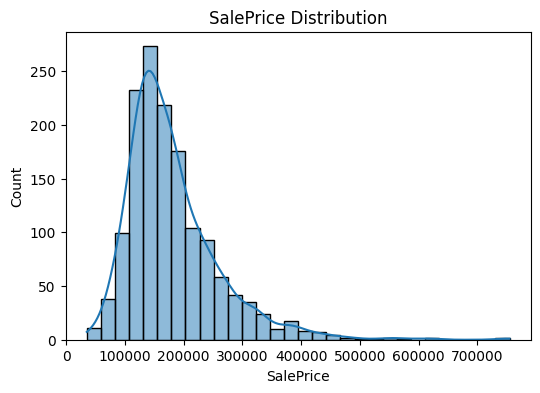

In [5]:
plt.figure(figsize=(6,4))
sns.histplot(train["SalePrice"], bins=30, kde=True)
plt.title("SalePrice Distribution")
plt.show()


## 🛠 Feature Engineering  

The dataset has many missing values. For numerical columns I will fill them with the median. For categorical columns I will use the most frequent value. Then I will log transform the SalePrice to reduce skewness.  

Categorical features will be encoded into numeric form using LabelEncoder so that models can handle them. Finally the features will be standardized with StandardScaler to bring them to a similar scale.


In [6]:
# Save target separately
y = train["SalePrice"]
X = train.drop("SalePrice", axis=1)

# Concatenate train and test for consistent preprocessing
all_data = pd.concat([X, test], axis=0)

# Fill missing values
for col in all_data.columns:
    if all_data[col].dtype == "object":
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
    else:
        all_data[col] = all_data[col].fillna(all_data[col].median())

# Encode categorical features
for col in all_data.columns:
    if all_data[col].dtype == "object":
        le = LabelEncoder()
        all_data[col] = le.fit_transform(all_data[col])

# Split back
X = all_data.iloc[:len(train), :]
X_test = all_data.iloc[len(train):, :]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Log transform target
y_log = np.log1p(y)


## 🤖 Model Training  

I will begin with Linear Regression as a baseline. Then I will train Ridge and Lasso regression which include regularization to handle multicollinearity. Random Forest and XGBoost will also be tested since they often perform well on tabular data.  

Evaluation will be done using Root Mean Squared Error (RMSE) with cross-validation. Lower RMSE means better performance.


In [7]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=10),
    "Lasso": Lasso(alpha=0.001),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, random_state=42)
}

results = {}

for name, model in models.items():
    scores = -cross_val_score(model, X_scaled, y_log, cv=5, scoring="neg_root_mean_squared_error")
    results[name] = scores.mean()
    print(f"{name}: RMSE = {scores.mean():.4f}")


Linear Regression: RMSE = 18221065687.9722
Ridge: RMSE = 0.1527
Lasso: RMSE = 0.1494
Random Forest: RMSE = 0.1422
XGBoost: RMSE = 0.1259


## 📊 Model Comparison  

The results below show which models performed best. I will visualize them for clarity.


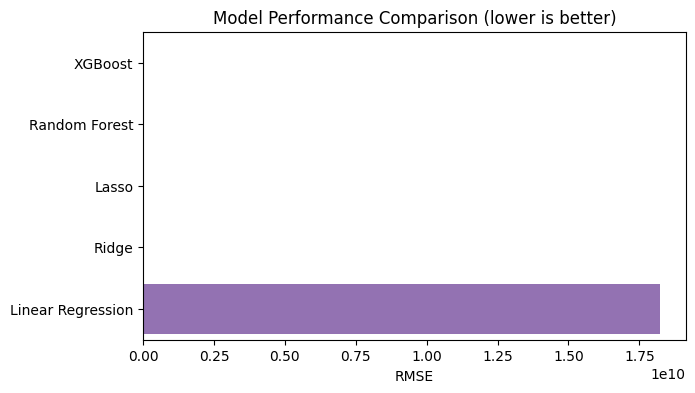

,RMSE
XGBoost,1.258964e-01
Random Forest,1.421768e-01
Lasso,1.493802e-01
Ridge,1.527497e-01
Linear Regression,1.822107e+10


In [8]:
results_df = pd.DataFrame.from_dict(results, orient="index", columns=["RMSE"])
results_df.sort_values(by="RMSE", inplace=True)

plt.figure(figsize=(7,4))
sns.barplot(x=results_df["RMSE"], y=results_df.index)
plt.title("Model Performance Comparison (lower is better)")
plt.show()

results_df


## 🏆 Final Model and Submission  

Based on cross validation scores I will use XGBoost for the final predictions. The model will be trained on the full training data and predictions will be generated for the test set. Since we log transformed the target earlier, we will apply the exponential transformation to bring predictions back to the original scale.


In [9]:
final_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, random_state=42)
final_model.fit(X_scaled, y_log)

preds = final_model.predict(X_test_scaled)
preds_exp = np.expm1(preds)

final_submission = pd.DataFrame({
    "Id": submission["Id"],
    "SalePrice": preds_exp
})

final_submission.to_csv("submission.csv", index=False)
print("Submission file created:", final_submission.shape)
final_submission.head()


Submission file created: (1459, 2)


,Id,SalePrice
0,1461,121089.703125
1,1462,147800.500000
2,1463,187257.703125
3,1464,187934.687500
4,1465,174386.734375


## ✨ Conclusion  

We explored the House Prices dataset and handled missing values, categorical encoding and scaling. Multiple models were trained and compared using RMSE.  

XGBoost achieved the best performance and was used for the final submission. This notebook shows how different parts of the machine learning pipeline come together in a regression problem.  

The next steps could include more advanced feature engineering, hyperparameter tuning and stacking models. But for now this provides a complete end to end workflow for predicting house prices.
